# 9.2. 长短期记忆网络（LSTM）

长期以来，隐变量模型存在着长期信息保存和短期输入缺失的问题。 解决这一问题的最早方法之一是长短期存储器（long short-term memory，LSTM） (Hochreiter and Schmidhuber, 1997)。 它有许多与门控循环单元（ 9.1节）一样的属性。 有趣的是，长短期记忆网络的设计比门控循环单元稍微复杂一些， 却比门控循环单元早诞生了近20年。

# 9.2.1. 门控记忆元

长短期记忆网络引入了**记忆元（memory cell）**，或简称为**单元（cell）**。 有些文献认为记忆元是隐状态的一种特殊类型， 它们与隐状态具有相同的形状，其设计目的是用于记录附加的信息。 为了控制记忆元，我们需要许多门。 其中一个门用来从单元中输出条目，我们将其称为输出门（output gate）。 另外一个门用来决定何时将数据读入单元，我们将其称为输入门（input gate）。 我们还需要一种机制来重置单元的内容，由遗忘门（forget gate）来管理， 这种设计的动机与门控循环单元相同， 能够通过专用机制决定什么时候记忆或忽略隐状态中的输入。

#  9.2.1.1. 输入门、忘记门和输出门

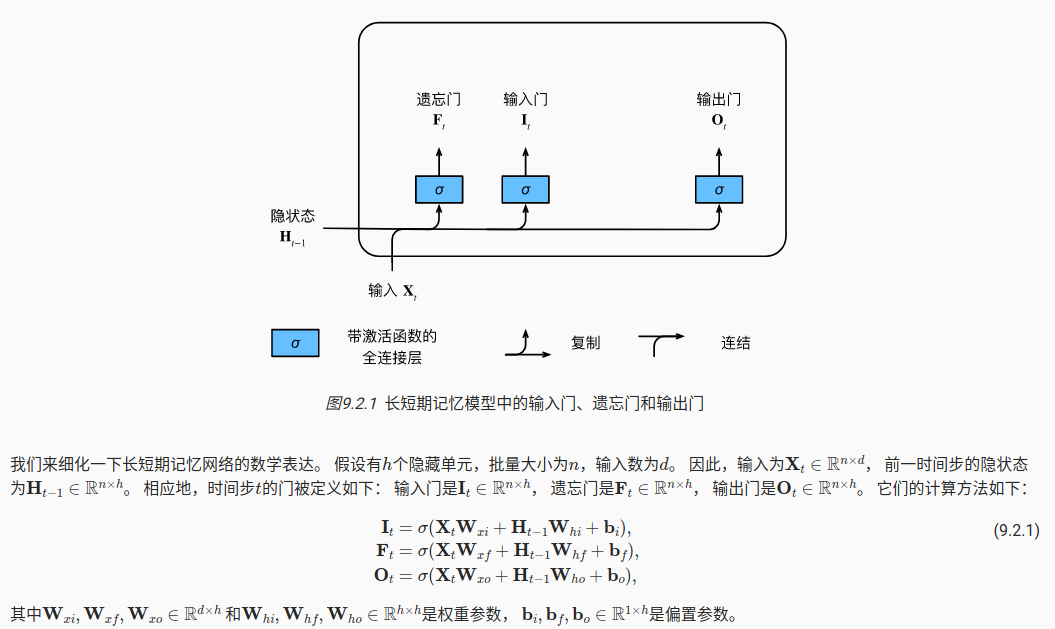

## 9.2.1.2. 候选记忆元

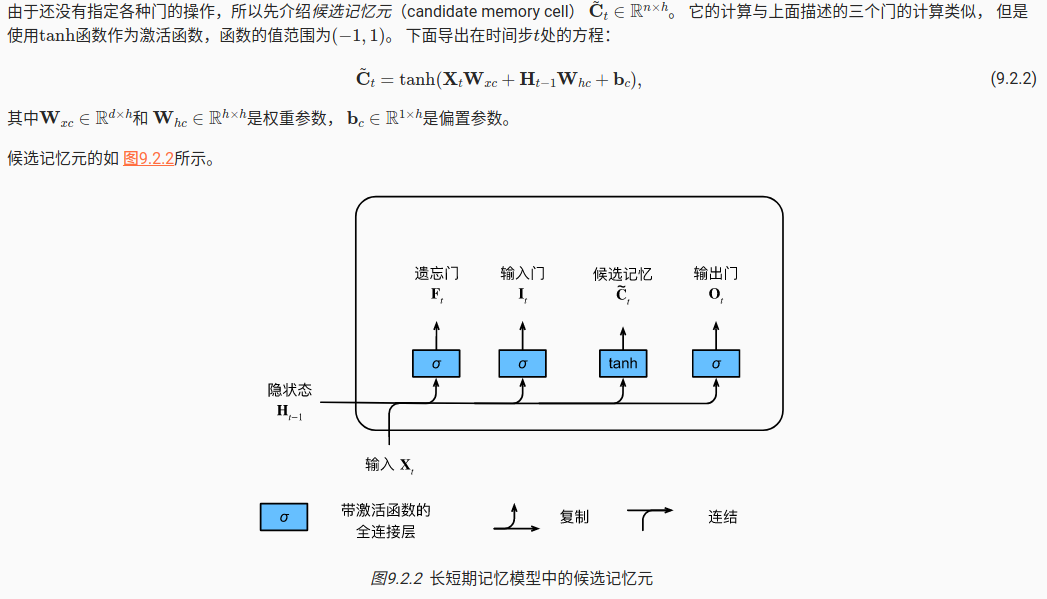

## 9.2.1.3. 记忆元

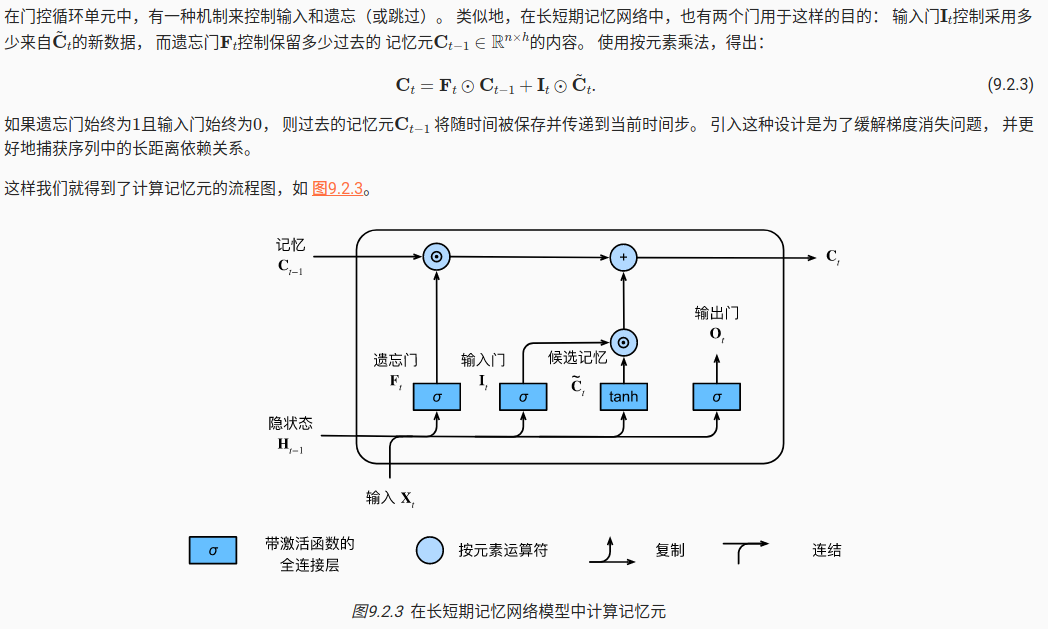

## 9.2.1.4. 隐状态

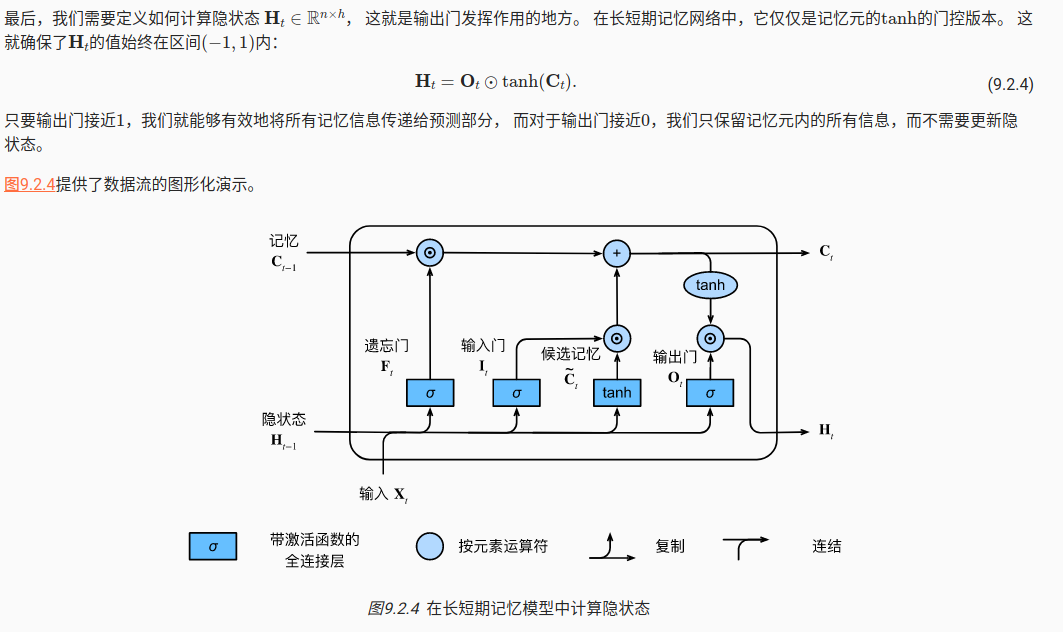

# 9.2.2. 从零开始实现

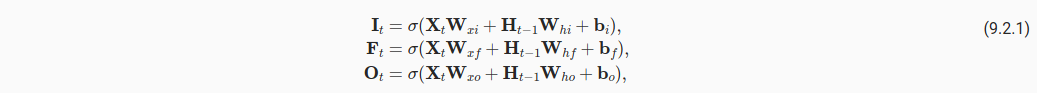
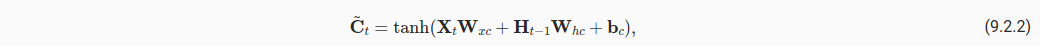
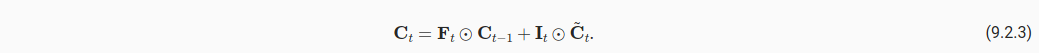

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 9.2.2.1. 初始化模型参数

与GRU基本一样，4组参数+1组输出层参数

In [7]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数：前面都是更新H的，还需要输出Y=[Ht * W_hq + b_q]
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 9.2.2.2. 定义模型

与GRU类似，一个初始返回隐藏层函数，一个前向函数。  
- 隐藏层函数因为多一个记忆元返回不同。  
- 前向函数与GRU不同，按具体公式来。

In [8]:
# 在初始化时返回隐状态。 这个函数的返回是2个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros(size=(batch_size, num_hiddens), device=device), 
            torch.zeros(size=(batch_size, num_hiddens), device=device))

前向函数有一个很大的不同就是state从只有H转变为(H, C)对

In [9]:
# lstm前向：返回输出Y序列和state对
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    H, C = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        # some output
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

## 9.2.2.3. 训练和预测

perplexity 1.4, 36241.9 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwal n
travelleryou can show black is white by are fores on shich 


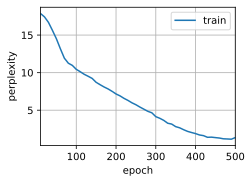

In [10]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1

model = d2l.RNNModelScratch(vocab_size=vocab_size, num_hiddens=num_hiddens, device=device, 
                            get_params=get_lstm_params, init_state=init_lstm_state, forward_fn=lstm)
d2l.train_ch8(net=model, train_iter=train_iter, vocab=vocab, lr=lr, num_epochs=num_epochs, device=device)

# 9.2.3. 简洁实现

perplexity 1.0, 264210.0 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


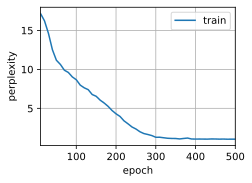

In [11]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)

model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

长短期记忆网络是典型的具有重要状态控制的隐变量自回归模型。 多年来已经提出了其许多变体，例如，多层、残差连接、不同类型的正则化。 然而，由于序列的长距离依赖性，训练长短期记忆网络 和其他序列模型（例如门控循环单元）的成本是相当高的。 在后面的内容中，我们将讲述更高级的替代模型，如Transformer。

# 9.2.4. 小结

- 长短期记忆网络有三种类型的门：输入门、遗忘门和输出门。

- 长短期记忆网络的隐藏层输出包括“隐状态”和“记忆元”。只有隐状态会传递到输出层，而记忆元完全属于内部信息。

- 长短期记忆网络可以缓解梯度消失和梯度爆炸。

# 9.2.5. 练习